# Setup

In [1]:
# Download project
!git clone https://github.com/ser-ge/ask_before_you_act

Cloning into 'ask_before_you_act'...
remote: Enumerating objects: 1751, done.
remote: Counting objects: 100% (693/693), done.
remote: Compressing objects: 100% (457/457), done.
remote: Total 1751 (delta 377), reused 517 (delta 209), pack-reused 1058
Receiving objects: 100% (1751/1751), 36.36 MiB | 31.77 MiB/s, done.
Resolving deltas: 100% (1035/1035), done.


In [2]:
cd ./ask_before_you_act/

/content/ask_before_you_act


In [3]:
%%capture
# Install dependencies
!pip install gym_minigrid lark wandb einops

In [4]:
!git pull
%load_ext autoreload
%autoreload 2

Already up to date.


In [5]:
# Import dependencies
import gym
import gym_minigrid
from oracle.oracle import OracleWrapper
from dataclasses import dataclass, asdict
from language_model import Dataset, Model as QuestionRNN
from utils.demo import render_episode, wrap_env_video_monitor, render_qa, show_question_input, render_env
from utils.agent import load_agent
from utils import default_config
from utils.env import make_env

# Agent

This loads one of our pre-trained agents and runs it on a random intitialization of the MiniGrid environment.

The agent asks a question at every step, receives an answer from the Oracle, takes an action, and remembers what he just did.

We initially pre-train the agent on the simpler *MiniGrid-MultiRoom-N2-S4-v0* environment. We then train the agent on a novel environment: the larger, and more complex *MiniGrid-MultiRoom-N4-S5-v0* environment. Both environments are randomly procedurally generated with varying door colours and room locations. 

The following shows one episode of the agent acting and asking on the test environment.

In [8]:
# Load pre-trained agent
agent = load_agent('main_agent-test')

env = make_env('MiniGrid-MultiRoom-N4-S5-v0')
env = OracleWrapper(env)
env = wrap_env_video_monitor(env)

# Get first observation
obs = env.reset()
obs = env.reset()['image']

# Initialize agent memory randomly
hist_mem = agent.init_memory()

# Record list of question and answers
questions = []
answers = []

# Step for a maximum of 100 steps
for i in range(100):
    
    # Ask
    question, hidden_q, log_prob_qa, entropy_qa, q_embedding = agent.ask(obs, hist_mem[0]) # Generate question
    answer, reward_qa = env.answer(question) # Ask question
    questions.append(question) 
    answers.append(str(answer))
    answer = answer.encode() # Encode answer e.g. "False" -> [0, 0]

    # Act
    action, log_prob_act, entropy_act = agent.act(obs, answer, hidden_q, hist_mem[0], q_embedding) # Choose action
    next_obs, reward, done, _ = env.step(action) # Take action

    # Remember
    hist_mem = agent.remember(obs, action, answer, hidden_q, hist_mem)
    
    next_obs = next_obs['image']
    obs = next_obs

    if done: break # Stop if agent reached goal

env.close()
render_episode()
render_qa(questions, answers)

<IPython.core.display.Javascript object>

# Oracle

The Oracle has full observability over the environment and is able to answer *True* or *False* to questions in relation to each object in the environment. The questions are posed as predicates such as "*red door is closed*" and "*green goal is north*".

The Oracle is able to parse two types of predicate: 
1.   Direction predicates: the relative position of an object to the agent.
2.   State predicates: the current state of an object in the  environment.

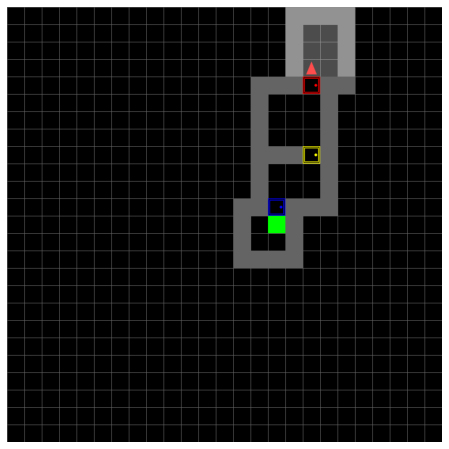

Text(value='Green goal is north?', description='Question:', placeholder='Green goal is north?')

'Green goal is north?'

'False'

'Green goal is south?'

'True'

'Yellow door is open?'

'False'

'Green door is open?'

'Undefined'

'NLP is the best module ever'

'Bad syntax'

'Green goal is west?'

'True'

In [9]:
env_name = 'MiniGrid-MultiRoom-N4-S5-v0' #@param ["MiniGrid-MultiRoom-N4-S5-v0", "MiniGrid-FourRooms-v0", "MiniGrid-DoorKey-16x16-v0"]
env = gym.make(env_name)
env = OracleWrapper(env)
obvs = env.reset()
for _ in range(0):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done: break
render_env(env)
show_question_input(env)